In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train.csv


In [3]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True


In [4]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [5]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [6]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = sorted(list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code'])))
    test['title_event_code'] = sorted(list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code'])))
    all_title_event_code = sorted(list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique())))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = sorted(list(set(train['title'].unique()).union(set(test['title'].unique()))))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = sorted(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
    list_of_event_id = sorted(list(set(train['event_id'].unique()).union(set(test['event_id'].unique()))))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = sorted(list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index))))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    train['hour'] = train['timestamp'].dt.hour
    test['hour'] = test['timestamp'].dt.hour
    train['weekday'] = train['timestamp'].dt.weekday
    test['weekday'] = test['timestamp'].dt.weekday
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [7]:
clip_time = {'Welcome to Lost Lagoon!':19,'Tree Top City - Level 1':17,'Ordering Spheres':61, 'Costume Box':61,
        '12 Monkeys':109,'Tree Top City - Level 2':25, 'Pirate\'s Tale':80, 'Treasure Map':156,'Tree Top City - Level 3':26,
        'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18,
        'Balancing Act':72, 'Lifting Heavy Things':118,'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19,
        'Heavy, Heavier, Heaviest':61}

In [8]:
def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

In [9]:
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    games_count = 0
    last_game_acc = 0
    accumulated_game_acc = 0
    forget_preserve_game_acc = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    Assessment_mean_event_count = 0
    Game_mean_event_count = 0
    Activity_mean_event_count = 0
    mean_game_round = 0
    mean_game_duration = 0 
    mean_game_level = 0
    accumulated_game_miss = 0
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    test_train_assessment = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    clip_durations = []
    Activity_durations = []
    Game_durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    accumulated_accuracy_title = {'accumulated_acc_' + title: 0 for title in assess_titles} ##################################3
    accumulated_title = {'accumulated_' + title: 0 for title in assess_titles} #####################################
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
        
        if session_type == 'Activity':
            Activity_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
        
        if session_type == 'Game':
            Game_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            game_s = session[session.event_code == 2030]   
            misses_cnt = cnt_miss(game_s)
            accumulated_game_miss += misses_cnt

            ############## 添加的game的准确度特征 #####################
            games = session.query(f'event_code == {4020}')
            game_correct = games['event_data'].str.contains('true').sum()
            game_uncorrect = games['event_data'].str.contains('false').sum()
            if game_correct + game_uncorrect > 0:
                games_count = games_count + 1
            last_game_acc = game_correct / (game_correct + game_uncorrect) if game_correct + game_uncorrect > 0 else 0
            forget_preserve_game_acc = (accumulated_game_acc + last_game_acc) / 2
            accumulated_game_acc = accumulated_game_acc + last_game_acc
            # games_count = games_count + 1
            ########################################################
            
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/2.0
            except:
                pass

            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) /2.0
            except:
                pass
            
            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) /2.0
            except:
                pass
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
#             features.update(accumulated_accuracy_title.copy()) ###############################3
#             features.update(last_accuracy_title.copy())
#             features.update(last_accuracy_title.copy())
            features['last_game_acc'] = last_game_acc
            features['accumulated_game_acc'] = accumulated_game_acc / games_count if games_count > 0 else 0
            features['forget_preserve_game_acc'] = forget_preserve_game_acc
            features['installation_session_count'] = sessions_count
            # #####################
#             features['hour'] = session['hour'].iloc[-1]
#             # features['weekday'] = session['weekday'].iloc[-1]
#             features['Assessment_mean_event_count'] = Assessment_mean_event_count
#             features['Game_mean_event_count'] = Game_mean_event_count
#             features['Activity_mean_event_count'] = Activity_mean_event_count
#             features['mean_game_round'] = mean_game_round
#             features['mean_game_duration'] = mean_game_duration
#             features['mean_game_level'] = mean_game_level
#             features['accumulated_game_miss'] = accumulated_game_miss
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
#             if clip_durations == []:
#                 features['Clip_duration_mean'] = 0
#                 features['Clip_duration_std'] = 0
#             else:
#                 features['Clip_duration_mean'] = np.mean(clip_durations)
#                 features['Clip_duration_std'] = np.std(clip_durations)
                
#             if Activity_durations == []:
#                 features['Activity_duration_mean'] = 0
#                 features['Activity_duration_std'] = 0
#             else:
#                 features['Activity_duration_mean'] = np.mean(Activity_durations)
#                 features['Activity_duration_std'] = np.std(Activity_durations)
                
#             if Game_durations == []:
#                 features['Game_duration_mean'] = 0
#                 features['Game_duration_std'] = 0
#             else:
#                 features['Game_duration_mean'] = np.mean(Game_durations)
#                 features['Game_duration_std'] = np.std(Game_durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            #########计算每个title的准确率#########
            if (true_attempts+false_attempts) != 0:
                accumulated_title['accumulated_' + session_title_text] += 1
                accumulated_accuracy_title['accumulated_acc_' + session_title_text] += last_accuracy_title['acc_' + session_title_text]
                accumulated_accuracy_title['accumulated_acc_' + session_title_text] = accumulated_accuracy_title['accumulated_acc_' + session_title_text] / accumulated_title['accumulated_' + session_title_text]
            #########计算每个title的准确率#########
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
                if true_attempts+false_attempts > 0:
                    test_train_assessment.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return test_train_assessment, all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [10]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    compiled_train_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_train, test_data = get_data(user_sample, test_set = True)
        compiled_train += test_train
        compiled_train_test += test_train
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    reduce_train_test = pd.DataFrame(compiled_train_test)
    categoricals = ['session_title']
    reduce_train.shape
    return reduce_train, reduce_test, reduce_train_test, categoricals

In [11]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [12]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'random_state':42,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params


In [13]:
class Xgb_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features_xgb = features.copy()
        all_train_test = pd.concat([train_df, test_df], axis=0)
        all_train_test = pd.get_dummies(all_train_test, prefix = ["session_title"], columns = ["session_title"])
        train_df1 = all_train_test[0:train_df.shape[0]]
        test_df1 = all_train_test[train_df.shape[0]:]
        features_xgb = features_xgb + ["session_title_4", "session_title_8", "session_title_9", "session_title_10", "session_title_30"]
        features_xgb.remove('session_title')
        super().__init__(train_df1, test_df1, features_xgb, categoricals, n_splits, verbose)
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'random_state':42,
            'gamma':0.25,
            'n_estimators':5000}

        return params


In [14]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True
                    }
        return params


In [15]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None


In [16]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(200, activation='relu')(x)
        #x = tf.keras.layers.LayerNormalization()(x)
        #x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [17]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, reduce_train_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [18]:
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
# stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [19]:
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]


In [20]:
to_remove = ['27253bdc', '2040', '37c53127', 'dcaede90', '26fd2d99', '08fd73f3', '2b9272f4', '73757a5e', 'Scrub_A_Dub_3021', 'Scrub_A_Dub_2050', 'Scrub_A_Dub_2030', 'Scrub_A_Dub_2020', 'Scrub_A_Dub_2040', 'Scrub_A_Dub_3121', '4235', '85de926c', 'ad148f58', 'Bubble_Bath_4235', 'Bubble_Bath_4230', '5010', '71e712d8', 'a6d66e51', 'Watering_Hole__Activity__5010', 'Watering_Hole__Activity__5000', '3010', '3020', '3021', '1996c610', 'Dino_Drink_4031', 'installation_session_count', 'a1192f43', 'Crystals_Rule_4050', '2030', '1340b8d7', 'Bubble_Bath_4220', 'df4fe8b6', 'Chest_Sorter__Assessment__3020', 'Chest_Sorter__Assessment__3120', 'Flower_Waterer__Activity__4090', 'd06f75b5', '1beb320a', '8f094001', '895865f3', 'c54cf6c5', 'Bubble_Bath_2025', 'Bubble_Bath_4020', 'Bubble_Bath_4045', 'Bubble_Bath_2035', 'Bubble_Bath_2020', 'Bubble_Bath_2030', 'Bird_Measurer__Assessment__4030', 'Bird_Measurer__Assessment__2000', 'Sandcastle_Builder__Activity__4020', '38074c54', '3afb49e6', '222660ff', 'Chest_Sorter__Assessment__3021', 'Chest_Sorter__Assessment__2030', 'Chest_Sorter__Assessment__2010', 'Chest_Sorter__Assessment__3121', '9e4c8c7b', 'All_Star_Sorting_3010', 'All_Star_Sorting_3110', 'Egg_Dropper__Activity__4070', 'Leaf_Leader_2075', 'Bird_Measurer__Assessment__2030', 'Cart_Balancer__Assessment__3110', '15eb4a7d', 'Bubble_Bath_3010', 'Bubble_Bath_3110', 'Leaf_Leader_4090', 'Scrub_A_Dub_4070', 'Chest_Sorter__Assessment__4070', 'Bubble_Bath_2080', 'All_Star_Sorting_4090', 'Scrub_A_Dub_2080', 'Sandcastle_Builder__Activity__4021', '16dffff1', '77ead60d', 'Dino_Drink_3121', 'Dino_Drink_3021', 'Dino_Drink_2030', 'Cauldron_Filler__Assessment__2010', 'Chest_Sorter__Assessment__4040', 'Flower_Waterer__Activity__4022', '28a4eb9a', 'Dino_Dive_3020', 'Dino_Dive_3120', 'Happy_Camel_2083', 'Fireworks__Activity__2000', 'Bug_Measurer__Activity__2000', 'All_Star_Sorting_4095', '1c178d24', 'cf7638f3', 'a592d54e', 'Pan_Balance_3121', 'Pan_Balance_2030', 'Pan_Balance_3021', 'Pan_Balance_2020', 'beb0a7b9', 'Fireworks__Activity__3110', 'Fireworks__Activity__3010', 'Chicken_Balancer__Activity__4080', 'd88e8f25', 'Scrub_A_Dub_3020', 'Scrub_A_Dub_3120', '58a0de5c', 'f5b8c21a', 'Air_Show_3021', 'Air_Show_3121', 'Air_Show_2030', 'e5734469', 'Dino_Drink_3120', 'Dino_Drink_3020', 'Chow_Time_4090', 'Happy_Camel_4045', 'Pan_Balance_4035', 'Chicken_Balancer__Activity__4070', 'Mushroom_Sorter__Assessment__4070', 'Fireworks__Activity__4030', 'Dino_Dive_4090', 'Pan_Balance_4100', '1bb5fbdb', 'Sandcastle_Builder__Activity__3010', 'Sandcastle_Builder__Activity__3110', '5154fc30', '3babcb9b', '3ddc79c3', '3323d7e9', 'e720d930', 'Crystals_Rule_3110', 'Crystals_Rule_2020', 'Crystals_Rule_2030', 'Crystals_Rule_3121', 'Crystals_Rule_3021', 'Crystals_Rule_3010', 'Chicken_Balancer__Activity__4020', '923afab1', 'Cauldron_Filler__Assessment__3010', 'Cauldron_Filler__Assessment__3110', 'Bug_Measurer__Activity__4035', 'Egg_Dropper__Activity__4025', '1375ccb7', 'Bird_Measurer__Assessment__3010', 'Bird_Measurer__Assessment__3110', 'Bubble_Bath_4080', 'Cauldron_Filler__Assessment__4090', 'Fireworks__Activity__4070', 'Leaf_Leader_4020', 'Pan_Balance_4010', '36fa3ebe', 'c7fe2a55', 'Happy_Camel_2030', 'Happy_Camel_3121', 'Happy_Camel_3021', 'Leaf_Leader_4010', 'Pan_Balance_4090', 'Cart_Balancer__Assessment__4070', 'All_Star_Sorting_4080', '9b23e8ee', 'Egg_Dropper__Activity__2000', 'Egg_Dropper__Activity__2020', 'Dino_Drink_2070', 'Fireworks__Activity__4020', 'Air_Show_4070', 'Chow_Time_4080', 'Fireworks__Activity__4080', 'c277e121', 'd45ed6a1', 'All_Star_Sorting_3120', 'All_Star_Sorting_2025', 'All_Star_Sorting_3020', 'Air_Show_4020', 'Cauldron_Filler__Assessment__2000', 'b2e5b0f1', 'b74258a0', 'Cart_Balancer__Assessment__2010', 'Cart_Balancer__Assessment__2030', 'Cart_Balancer__Assessment__3121', 'Watering_Hole__Activity__4090', '7ad3efc6', 'Cart_Balancer__Assessment__2020', 'Cart_Balancer__Assessment__2000', 'b012cd7f', 'e5c9df6f', 'Leaf_Leader_3121', 'Leaf_Leader_2030', 'Leaf_Leader_3021', 'Bottle_Filler__Activity__4090', 'All_Star_Sorting_4030', 'Cart_Balancer__Assessment__4040', 'Bubble_Bath_4070', '67439901', 'Bottle_Filler__Activity__3010', 'Bottle_Filler__Activity__3110', 'Sandcastle_Builder__Activity__4035', '7f0836bf', 'Dino_Drink_3110', 'Dino_Drink_3010', 'Chow_Time_4010', '84b0e0c8', 'Chicken_Balancer__Activity__3010', 'Chicken_Balancer__Activity__3110', 'Happy_Camel_2000', 'Dino_Dive_2060', 'Bottle_Filler__Activity__4080', 'All_Star_Sorting_2020', 'Scrub_A_Dub_2000', 'Crystals_Rule_4010', 'Cart_Balancer__Assessment__4020', 'Happy_Camel_4010', '832735e1', 'Dino_Dive_3010', 'Dino_Dive_3110', 'Leaf_Leader_4095', 'Chest_Sorter__Assessment__4080', 'Bottle_Filler__Activity__4020', '49ed92e9', 'Watering_Hole__Activity__3010', 'Watering_Hole__Activity__3110', '7ab78247', 'Egg_Dropper__Activity__3110', 'Egg_Dropper__Activity__3010', '9d29771f', 'c74f40cd', '28ed704e', '83c6c409', 'Mushroom_Sorter__Assessment__2020', 'Mushroom_Sorter__Assessment__3021', 'Mushroom_Sorter__Assessment__4025', 'Mushroom_Sorter__Assessment__2035', 'Mushroom_Sorter__Assessment__3121', '3ccd3f02', 'Chest_Sorter__Assessment__3010', 'Chest_Sorter__Assessment__3110', 'Bubble_Bath_4090', 'b5053438', '28520915', 'Cauldron_Filler__Assessment__3121', 'Cauldron_Filler__Assessment__2030', 'Cauldron_Filler__Assessment__3021', 'Dino_Drink_2020', 'Watering_Hole__Activity__2000', 'Bird_Measurer__Assessment__2020', 'e57dd7af', 'Leaf_Leader_3120', 'Leaf_Leader_3020', '155f62a4', 'Chest_Sorter__Assessment__2000', 'Chest_Sorter__Assessment__2020', 'Bubble_Bath_2083', 'bbfe0445', 'Flower_Waterer__Activity__3010', 'Flower_Waterer__Activity__3110', 'a1e4395d', 'Mushroom_Sorter__Assessment__3010', 'Mushroom_Sorter__Assessment__3110', 'Mushroom_Sorter__Assessment__4100', 'Bubble_Bath_2000', 'Flower_Waterer__Activity__4025', 'Chow_Time_3010', 'Mushroom_Sorter__Assessment__4090', '17113b36', 'e37a2b78', 'Bird_Measurer__Assessment__3020', 'Bird_Measurer__Assessment__4110', 'Bird_Measurer__Assessment__3120', 'Mushroom_Sorter__Assessment__4080', 'Dino_Dive_4080', 'Dino_Drink_4010', 'Dino_Drink_4080', 'Egg_Dropper__Activity__4020', 'Leaf_Leader_2000', 'Dino_Drink_4070', '5290eab1', 'Cauldron_Filler__Assessment__3120', 'Cauldron_Filler__Assessment__3020', '6cf7d25c', 'Pan_Balance_3110', 'Pan_Balance_3010', '4b5efe37', 'All_Star_Sorting_4010', 'All_Star_Sorting_2000', 'Chicken_Balancer__Activity__4030', 'Chicken_Balancer__Activity__2000', 'Leaf_Leader_4080', 'Watering_Hole__Activity__4070', 'Air_Show_2060', 'Dino_Dive_2070', '8d7e386c', 'Happy_Camel_3110', 'Happy_Camel_3010', 'Happy_Camel_4035', 'Scrub_A_Dub_2081', 'Bottle_Filler__Activity__2000', 'Bird_Measurer__Assessment__2010', 'Bug_Measurer__Activity__4030', 'Air_Show_2070', 'Sandcastle_Builder__Activity__4070', 'Flower_Waterer__Activity__4030', '7423acbc', 'Air_Show_3020', 'Air_Show_3120', 'Dino_Dive_2020', 'Dino_Dive_4020', 'Chow_Time_2000', 'f71c4741', 'Scrub_A_Dub_3110', 'Scrub_A_Dub_3010', 'Watering_Hole__Activity__2010', 'Pan_Balance_4070', 'Pan_Balance_4080', 'Bird_Measurer__Assessment__4070', 'daac11b0', '1f19558b', 'All_Star_Sorting_3121', 'All_Star_Sorting_2030', 'All_Star_Sorting_3021', 'Chow_Time_4020', 'Cart_Balancer__Assessment__4030', 'Chow_Time_2020', '2fb91ec1', 'Watering_Hole__Activity__4020', 'Watering_Hole__Activity__4025', 'Flower_Waterer__Activity__4080', 'Leaf_Leader_4070', 'Cauldron_Filler__Assessment__4080', 'Happy_Camel_4070', 'Sandcastle_Builder__Activity__4030', 'a5be6304', 'Mushroom_Sorter__Assessment__2010', 'Mushroom_Sorter__Assessment__2030', 'Chow_Time_4030', 'Dino_Dive_4070', '709b1251', 'Dino_Dive_3121', 'Dino_Dive_3021', 'Pan_Balance_4030', 'Air_Show_4110', 'Crystals_Rule_2000', '45d01abe', 'Bird_Measurer__Assessment__3021', 'Bird_Measurer__Assessment__3121', 'Flower_Waterer__Activity__4070', 'Happy_Camel_2081', '37ee8496', 'Cauldron_Filler__Assessment__4030', 'Cauldron_Filler__Assessment__4020', 'Cart_Balancer__Assessment__4035', 'Mushroom_Sorter__Assessment__4030', 'Dino_Drink_4020', 'Pan_Balance_4025', '47026d5f', '56817e2b', 'Chow_Time_3021', 'Chow_Time_2030', 'Chow_Time_3121', '3bfd1a65', 'Mushroom_Sorter__Assessment__2000', 'Mushroom_Sorter__Assessment__2025', '55115cbd', 'Bubble_Bath_3021', 'Bubble_Bath_3121', 'Cart_Balancer__Assessment__4100', 'c51d8688', 'Pan_Balance_3120', 'Pan_Balance_3020', '88d4a5be', 'Mushroom_Sorter__Assessment__3120', 'Mushroom_Sorter__Assessment__3020', 'Bottle_Filler__Activity__4070', '0a08139c', 'Bug_Measurer__Activity__3110', 'Bug_Measurer__Activity__3010', 'Scrub_A_Dub_4020', 'Bug_Measurer__Activity__4025', 'Scrub_A_Dub_2083', 'Crystals_Rule_4070', 'Mushroom_Sorter__Assessment__4035', '3bf1cf26', 'Happy_Camel_3120', 'Happy_Camel_3020', 'Happy_Camel_4080', 'Bird_Measurer__Assessment__4100', 'Happy_Camel_2020', 'Air_Show_4010', 'Chicken_Balancer__Activity__4090', 'Leaf_Leader_2020', 'All_Star_Sorting_4035', 'Scrub_A_Dub_4010', 'All_Star_Sorting_4070', 'Scrub_A_Dub_4090', '44cb4907', 'Crystals_Rule_3120', 'Crystals_Rule_3020', 'Bird_Measurer__Assessment__4040', 'e9c52111', 'Bottle_Filler__Activity__2020', 'Bottle_Filler__Activity__2030', 'Chest_Sorter__Assessment__4090', 'Mushroom_Sorter__Assessment__4020', 'Cauldron_Filler__Assessment__2020', '31973d56', 'Cart_Balancer__Assessment__3120', 'Cart_Balancer__Assessment__3020', 'Bubble_Bath_4095', 'Happy_Camel_4095', 'Egg_Dropper__Activity__4080', 'Chicken_Balancer__Activity__4035', '0330ab6a', 'Chow_Time_3120', 'Chow_Time_3020', 'Bird_Measurer__Assessment__4080', 'Crystals_Rule_4020', 'Bird_Measurer__Assessment__4035', 'Leaf_Leader_2070', 'Cart_Balancer__Assessment__3021', 'Fireworks__Activity__4090', 'Happy_Camel_4030', 'Leaf_Leader_2060', 'Bubble_Bath_4040', 'Cauldron_Filler__Assessment__4100', 'Air_Show_4100', 'Chest_Sorter__Assessment__4020', 'Pan_Balance_4020', 'Air_Show_2075', 'Watering_Hole__Activity__4021', 'Cauldron_Filler__Assessment__4025', 'Air_Show_2000', 'Chow_Time_4070', 'Dino_Dive_2000', 'Pan_Balance_2000', 'Cart_Balancer__Assessment__3010', 'Dino_Drink_4030', 'Mushroom_Sorter__Assessment__4040', 'Chow_Time_4095', 'Bubble_Bath_4010', 'Cart_Balancer__Assessment__4090', 'Chow_Time_4035', 'Dino_Drink_4090', 'a1bbe385', 'Air_Show_3110', 'Air_Show_3010', 'Flower_Waterer__Activity__4020', 'Chow_Time_3110', 'Chest_Sorter__Assessment__4030', 'Bug_Measurer__Activity__4090', 'Flower_Waterer__Activity__2000', '5859dfb6', 'Bubble_Bath_3120', 'Bubble_Bath_3020', 'Bug_Measurer__Activity__4080', 'Happy_Camel_4090', 'Happy_Camel_4020', 'Cart_Balancer__Assessment__4080', 'Air_Show_4090', 'Cauldron_Filler__Assessment__4040', 'Dino_Dive_2030', 'Egg_Dropper__Activity__4090', '33505eae', 'Leaf_Leader_3010', 'Leaf_Leader_3110', 'Dino_Drink_2060', 'Chicken_Balancer__Activity__4022', 'Cauldron_Filler__Assessment__4035', 'Dino_Drink_2075', 'Happy_Camel_2080', 'Sandcastle_Builder__Activity__2000', 'Cauldron_Filler__Assessment__4070', 'Bird_Measurer__Assessment__4025', 'Sandcastle_Builder__Activity__4080', 'Sandcastle_Builder__Activity__4090', 'Dino_Dive_4010', 'All_Star_Sorting_4020', 'Bottle_Filler__Activity_', 'Bottle_Filler__Activity__4030', 'Crystals_Rule_4090', 'Chest_Sorter__Assessment__4035', 'Bird_Measurer__Assessment__4090', 'Bird_Measurer__Assessment__4020', 'Chest_Sorter__Assessment__4100', 'Bottle_Filler__Activity__4035', 'Chest_Sorter__Assessment__4025', 'Dino_Drink_2000', 'Happy_Camel_4040', 'Air_Show_2020', 'Bug_Measurer__Activity__4070', 'Welcome_to_Lost_Lagoon__2000', 'Tree_Top_City___Level_3_2000', 'Costume_Box_2000', 'Heavy__Heavier__Heaviest_2000', 'Magma_Peak___Level_2_2000', 'Ordering_Spheres_2000', 'Crystal_Caves___Level_2_2000', 'Magma_Peak___Level_1_2000', 'Slop_Problem_2000', 'Crystal_Caves___Level_3_2000', 'Balancing_Act_2000', '12_Monkeys_2000', 'Honey_Cake_2000', 'Crystal_Caves___Level_1_2000', 'Treasure_Map_2000', 'Rulers_2000', 'Tree_Top_City___Level_2_2000', 'Tree_Top_City___Level_1_2000', 'Lifting_Heavy_Things_2000', 'Pirate_s_Tale_2000', 'var_title_event_code']
features = sorted(features)
# counter = 0
# # to_remove = []
# features = [x for x in features if x not in to_remove]
# for feat_a in features:
#     for feat_b in features:
#         if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
#             c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
#             if c > 0.995:
#                 counter += 1
#                 to_remove.append(feat_b)
#                 print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

In [21]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

003cd2ee 0.0 0.0
01ca3a3c 0.00040592652729855896 0.0
0ce40006 0.000761112238684798 0.0
119b5b02 0.00025370407956159933 0.0
13f56524 0.03942561396387254 0.0
17ca3959 0.0 0.0
1b54d27f 0.0006596306068601583 0.0
29a42aea 0.0036533387456870307 0.0
2ec694de 0.00806778973005886 0.0
4074bac2 0.0 0.0
5dc079d8 0.0 0.0
611485c5 0.0012177795818956768 0.0
6aeafed4 0.13415871727217374 0.008 0.0
7fd1ac25 0.017759285569311955 0.0
a8cc6fec 0.0 0.0
ab4ec3a4 0.0008118530545971179 0.0
bfc77bd6 0.01151816521209661 0.0
dcb1663e 0.0 0.0
e4d32835 0.001167038765983357 0.0
eb2c19cd 0.1565354170895068 0.008 0.0
ecc6157f 0.006545565252689263 0.0
Air_Show_4080 0.0020296326364927946 0.0
Air_Show_4090 1.2013395575400851 0.018 0.0
Air_Show_4100 15.244570732697381 0.773 0.0
Air_Show_4110 3.2098132737974425 0.217 0.0
All_Star_Sorting_3021 52.278770042622284 1.44 0.0
All_Star_Sorting_4010 0.03470671808402679 0.548 0.0
All_Star_Sorting_4080 0.024812258981124418 0.002 0.0
Bird_Measurer__Assessment__4040 0.0 0.097 0.0
Bott

In [22]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape


(19708, 367)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03316	valid_1's rmse: 1.04951
[200]	training's rmse: 0.965692	valid_1's rmse: 0.998808
[300]	training's rmse: 0.933425	valid_1's rmse: 0.984218
[400]	training's rmse: 0.91131	valid_1's rmse: 0.978819
[500]	training's rmse: 0.893319	valid_1's rmse: 0.976238
[600]	training's rmse: 0.877711	valid_1's rmse: 0.974994
[700]	training's rmse: 0.863686	valid_1's rmse: 0.974762
[800]	training's rmse: 0.850724	valid_1's rmse: 0.974767
Early stopping, best iteration is:
[723]	training's rmse: 0.860547	valid_1's rmse: 0.974449
Partial score of fold 0 is: 0.599480245146407
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03312	valid_1's rmse: 1.04302
[200]	training's rmse: 0.967473	valid_1's rmse: 0.993276
[300]	training's rmse: 0.936042	valid_1's rmse: 0.978802
[400]	training's rmse: 0.913966	valid_1's rmse: 0.973023
[500]	training's rmse: 0.89637	valid_1's rmse: 0.970469
[60

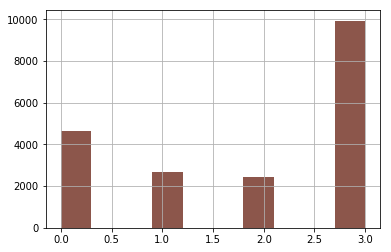

In [23]:
# cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
# 
# 

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.86263	val-rmse:1.86364
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.01254	val-rmse:1.1499
[200]	train-rmse:0.741384	val-rmse:1.00779
[300]	train-rmse:0.63737	val-rmse:0.985878
[400]	train-rmse:0.587063	val-rmse:0.98368
Stopping. Best iteration:
[390]	train-rmse:0.591285	val-rmse:0.983629

Partial score of fold 0 is: 0.5875508984532429
[0]	train-rmse:1.86271	val-rmse:1.86345
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.01363	val-rmse:1.14321
[200]	train-rmse:0.747092	val-rmse:0.997699
[300]	train-rmse:0.647018	val-rmse:0.973652
[400]	train-rmse:0.590931	val-rmse:0.970155
[500]	train-rmse:0.55507	val-rmse:0.970147
Stopping. Best iteration:
[454]	train-rmse:0.569269	val-rmse:0.969708

Partial score of fold 1 is: 0.6004691585343398
[0]	train-rms

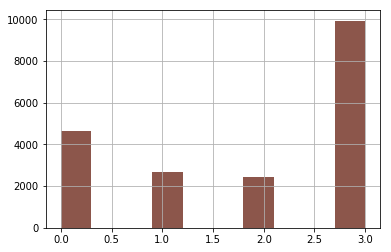

In [24]:
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:100: DeprecationWarning: The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


(19708, 372)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               74600     
_________________________________________________________________
layer_normalization (LayerNo (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)    

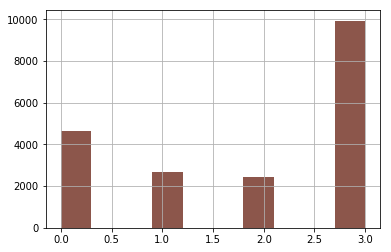

In [25]:
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [26]:
clparams   = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1, 
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 
            'bagging_fraction_seed': 127,
            'feature_fraction_seed': 127,
            'data_random_seed': 127,
            'seed':127
            }

In [27]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
import time
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
n_fold = 5
# folds = GroupKFold(n_splits=n_fold)
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
X = reduce_train.copy()
cl_y = reduce_train['accuracy_group'].copy()
cl_y.loc[cl_y>0]=1
cols_to_drop = ['installation_id','accuracy_group']
cl_oof = np.zeros(len(reduce_train))
models = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(X, cl_y, X['installation_id'])):
    print('Fold {} started at {}'.format(fold_n+1,time.ctime()))
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = cl_y.iloc[train_index], cl_y.iloc[valid_index]
    
    X_train = X_train.drop(cols_to_drop,axis=1)
    X_valid = X_valid.drop(cols_to_drop,axis=1)
    
    trn_data = lgb.Dataset(X_train,label=y_train)
    val_data = lgb.Dataset(X_valid,label=y_valid)
    
    cl_lgb_model = lgb.train(clparams,
                        trn_data,
                        valid_sets=[trn_data,val_data],
                        verbose_eval=100,
                        categorical_feature = categoricals
                        )
    pred = cl_lgb_model.predict(X_valid)
    models.append(cl_lgb_model)
    cl_oof[valid_index] = pred

Fold 1 started at Wed Jan 22 19:53:03 2020


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['session_title']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.911608	valid_1's auc: 0.860359
[200]	training's auc: 0.94207	valid_1's auc: 0.865487
[300]	training's auc: 0.960668	valid_1's auc: 0.867372
[400]	training's auc: 0.972932	valid_1's auc: 0.867706
Early stopping, best iteration is:
[363]	training's auc: 0.969046	valid_1's auc: 0.868143
Fold 2 started at Wed Jan 22 19:53:24 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.910398	valid_1's auc: 0.873022
[200]	training's auc: 0.942022	valid_1's auc: 0.877035
[300]	training's auc: 0.960832	valid_1's auc: 0.877528
Early stopping, best iteration is:
[244]	training's auc: 0.951313	valid_1's auc: 0.877913
Fold 3 started at Wed Jan 22 19:53:43 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.910851	valid_1's auc: 0.86844
[200]	training's auc: 0.941864	valid_1's auc: 0.873152
[300]	training's auc: 0.961493	valid_1's auc: 0.873673


0.5786400523744044


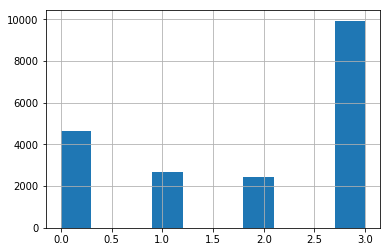

In [28]:
_, loss_score, _ = eval_qwk_lgb_regr(reduce_train['accuracy_group'], cl_oof*3)
print (loss_score)

In [29]:
def cl_predict(x,models):
    all_ans = np.zeros((len(x)))
    cols_to_drop = ['installation_id','accuracy_group']
    test_copy = x.drop(cols_to_drop,axis=1)
    for model in models:
        ans = model.predict(test_copy)
        all_ans += ans
        
    return all_ans/n_fold

class_pred = cl_predict(ajusted_test, models)

In [30]:


weights = {'lbg': 0.4, 'cls': 0.2, 'xgb': 0.3, 'nn': 0.1}

final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'] + (3*class_pred * weights['cls']))
#final_pred = cnn_model.y_pred
# final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) + (cat_model.y_pred * weights['cat'])
print(final_pred.shape)



(1000,)


{0: 1.4440512385729405, 1: 1.8443449155461984, 2: 2.095548181937612}


3    0.504
0    0.236
1    0.136
2    0.124
Name: accuracy_group, dtype: float64

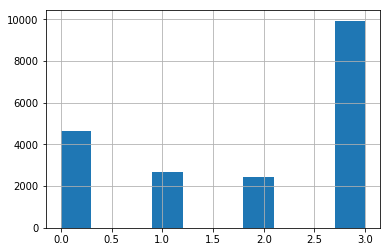

In [31]:
dist = Counter(reduce_train['accuracy_group'])
# dist[0] = 0.261
# dist[1] = 0.116
# dist[2] = 0.119
# dist[3] = 0.504
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)